# W207 Final Project: Facial Recognition

### Team: MapReduce, MapReuse, MapRecycle
Members: Tennison Yu, Madeleine Bulkow, Mark Paluta, Alex Dauenhauer

https://github.com/tyu0912/MIDS_W207_facial_recognition/issues

# Introduction

This is the final project submission from Team MapReduce,MapReuse,MapRecycle for W207: Applied Machine Learning as part of the MIDS program at UC Berkeley. We are working with data from https://www.kaggle.com/c/facial-keypoints-detection/data and the goal is to accurately identify facial features on an (x, y) coordinate system based on an input image of a face. Facial features can be more accurately described as eyes, nose, and mouth.

## Overall Project Flow

Our project is layed out into the following parts:

1) Exploratory Data Analysis (EDA) - We explore the data and see what the images and labels we are working with are like

2) Feature Engineering - We alter/augment images to expand our training set to better cover edge cases and generalize the algorithm. Based on our exploration of common standard techniques done, we decided to flip, contrast, blur, and rotate the images.

3) Simple Modeling - We explore the effectiveness of simple algorithms such as Decision Trees and Neast Neighbors and compare and contrast their effectiveness. 

4) Complex Modeling - We explore the effectiveness of a more complex model, convoluted neural networks (CNN).

5) Summary and Apply - We present our findings and apply our best predictive algorithm to the test data that Kaggle provided us to see how well we did. 

# Import Packages, Load data

In [46]:
# # Optional cell to install/update all required packages
# ! pip install keras tensorflow numpy pandas matplotlib scipy imgaug opencv-python pydot graphviz > nul
# ! conda install shapely > nul
# print('Packages installed, output supressed for cleanliness')

In [1]:
import time, sys, os, keras, tensorflow as tf, warnings, imgaug as ia
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pydot, graphviz
from importlib import reload
from sklearn.utils import shuffle
from keras import backend as K
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, mean_squared_error
from scipy import stats
from imgaug import augmenters as iaa #We noticed this package does sometimes break (No GammaContrast) after install. Replace local folder with attached if happens.
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# set tensorflow as keras backend
if K.backend() not in ["tensorflow", 'plaidml']:
    print ('Switching keras backend...')
    os.environ['KERAS_BACKEND'] = "tensorflow"
    reload(K)
    
print('keras version:', keras.__version__)
print('tensorflow version:', tf.__version__)
print('pandas version:', pd.__version__)
print('numpy version:', np.__version__)

# Initiate settings and load the data.
np.random.seed(0)
pd.options.display.max_columns = 30
warnings.filterwarnings('ignore')

train = pd.read_csv('training.csv')
test = pd.read_csv('test.csv')

print ('Everything Loaded Successfully')

C:\Users\alexd\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
pandas version: 0.23.0
numpy version: 1.14.3
Everything Loaded Successfully


# EDA

We begin by exploring our data. It is important to understand the range of values we can take on, whether there is missing data, and whether there might be erroneous data. We will be exploring primarily on the image level, as opposed to on the individual keypoint or pixel level, because pixels and keypoints tell a much more important story via their relationship to one another rather than in isolation.

## Glancing at the Data

First, we will see the format our data is in. They keypoints are provided in x or y coordinate floats.

In [48]:
train[train.columns[:-1]].head(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


The pixels are in a greyscale 8-bit format (range 0 to 255).

In [49]:
train['Image'].head(5)

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

Our first interesting observation is that not all of the images contain all keypoints. In fact no keypoint is present in every image and many are present in less than half of the images. 

In [50]:
print(train.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

From the above cells, we can see that we are given x,y coordinates for our different features in seperate columns. As well, images are currently strings with each pixel value separated by a space. We will need to manipulate these to a form we can work with such as numpy arrays.

Additionally, many labels have a lot of missing data. The only label that is complete appears to be the nose tip.

## Reformatting the Data

It seems for complex models such as the CNN, keras requires the data to be in numpy array form with dimensions = (batch, image_width, image_height, num_channels). Images in dataset are 96x96 grayscale images, therefore shape should be (X, 96, 96, 1).

To ensure we have data to work stored away for development, we will also split the training set into 80% train data and 20% dev data in the steps below.

In [51]:
def process_datasets(df, test=False, fillna=False, dropna=False):
    '''This function reformats the data from a dataframe to a numpy
    array of the appropriate shape.
    '''

    # whether or not to remove images with missing labels
    if dropna:
        df = df.dropna()
    
    # build feature dict for reference in future functions
    feature_dict = {label:i for i,label in enumerate(df.columns[:-1].values)}
    
    # separate images into numpy arrays
    images_pixel_feature = df.Image.apply(lambda im: np.fromstring(im, sep=' '))
    
    # rescale pixel values to [0,1] interval and reshape
    images_pixel_feature = np.stack(images_pixel_feature) / 255
    images_pixel_feature = images_pixel_feature.reshape(-1, 96, 96, 1)
    
    
    # separate the labels and scale them to [-1,1] interval for use of 
    # rectified linear unit activation
    if not test:
        facial_point_labels = df.iloc[:, :-1]
        if fillna:
            facial_point_labels.fillna(np.mean(facial_point_labels, axis=0), inplace=True)
        facial_point_labels = facial_point_labels.values
        facial_point_labels = (facial_point_labels - 48) / 48
    else:
        facial_point_labels = None
    
    return images_pixel_feature, facial_point_labels, feature_dict

In [52]:
# Raw data
# train_raw = processed but not split
train_data_raw, train_labels_raw, feature_dict = process_datasets(train)
test_data, test_labels, _ = process_datasets(test, test=True)

## Examine Random Sample

Here we wanted to observe some sample images with labels to see what kind of variety of images we are working with. 

In [53]:
def plot_sample(data, labels, labels2=None):
    '''
    data must be a numpy.ndarray of shape (X, 96, 96, 1)
    labels must be a numpy.ndarray (X, 30)
    X must be any square number
    labels = true labels
    labesl2 = predicted labels (optional)
    '''
    
    dim = np.sqrt(len(data))
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(len(labels)):
        img = data[i].reshape(96,96)
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(96,96), cmap='gray')
        ax.scatter(labels[i][0::2] * 48 + 48, labels[i][1::2] * 48 + 48, c='r')
        if not labels2 is None:
            ax.scatter(labels2[i][0::2] * 48 + 48, labels2[i][1::2] * 48 + 48, c='b')

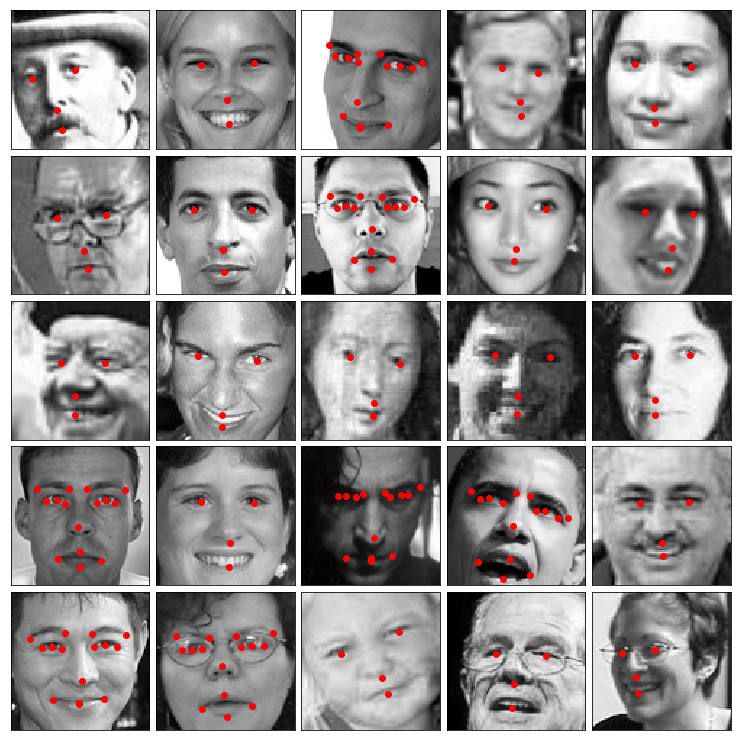

In [54]:
# Output sample of random images. Some of these will be the NA data
n = 25
idx = np.random.randint(0, len(train_data_raw), n)
data_sample = train_data_raw[idx, :, :, :]
label_sample = train_labels_raw[idx, :]
plot_sample(data_sample, label_sample)

## Examine Edge Cases

In addition to random faces, we wondered what some edge cases are like. 

In [55]:
edge_cases = []

# --- compile interesting cases --- 

# noses on the side of the image may imply a profile shot
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_x']].argsort()[:8])           # left profiles
edge_cases.extend(train_labels_raw[:,feature_dict['nose_tip_x']].argsort()[-8:])          # right profiles

# max differential in eye height will imply clocking
edge_cases.extend((train_labels_raw[:,feature_dict['right_eye_center_y']] -               # faces tilted right
                   train_labels_raw[:,feature_dict['left_eye_center_y']]).argsort()[:8])  
edge_cases.extend((train_labels_raw[:,feature_dict['left_eye_center_y']] -                # faces tilted left
                   train_labels_raw[:,feature_dict['right_eye_center_y']]).argsort()[:8]) 

# faces vary in width
edge_cases.extend((train_labels_raw[:,feature_dict['right_eye_center_x']] -               # wide faces
                   train_labels_raw[:,feature_dict['left_eye_center_x']]).argsort()[:8])  
edge_cases.extend((train_labels_raw[:,feature_dict['left_eye_center_x']] -                # thin faces
                   train_labels_raw[:,feature_dict['right_eye_center_x']]).argsort()[:8]) 

# investigate very dark or light faces to see if we have different races or lighting
edge_cases.extend(np.sum(train_data_raw.reshape(train_data_raw.shape[0], 96*96), axis=1).argsort()[:8])      # dark faces
edge_cases.extend(np.sum(train_data_raw.reshape(train_data_raw.shape[0], 96*96), axis=1).argsort()[-8:])     # light faces

print(len(edge_cases), edge_cases)

data_edge = train_data_raw[edge_cases, :, :, :]
label_edge = train_labels_raw[edge_cases, :]

64 [1907, 6315, 1652, 1620, 6271, 2845, 2191, 1966, 1877, 3188, 2075, 6834, 2199, 6493, 2175, 4263, 3179, 6087, 4693, 6252, 4363, 4645, 6240, 5636, 3173, 1720, 4775, 2893, 4112, 3410, 1704, 2597, 1747, 2289, 6859, 2572, 2776, 3152, 5167, 6585, 6492, 6493, 6405, 4263, 1861, 4490, 6765, 5117, 166, 943, 286, 2415, 1149, 6200, 4983, 2557, 6126, 700, 4335, 5771, 1067, 1054, 2907, 6270]


The rows of the following image are meant to illustrate, respectively:
- left profiles
- right profiles
- tilted right
- tilted left
- wide faces
- thin faces
- dark faces
- light faces

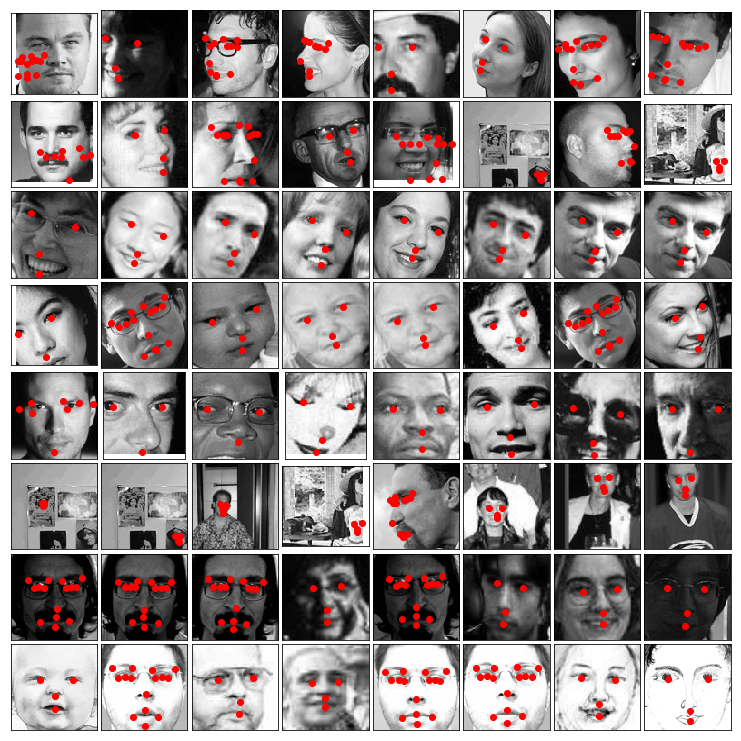

In [56]:
plot_sample(data_edge, label_edge)

From the above, it looks like there are several different types of edge cases. We can see there are a variety of angles, lighting, tilts, resolutions, and even a drawing (bottom right corner). Some cases look like purely bad data that may need to be removed such as the first picture of Leonardo DiCaprio. Also interesting is that there are images that are the same subject.

### Removing erroneous data  
To remove the data that we considered bad data, we utilized a method that will be covered in our appendix to flag likely erroneous images. They are printed here to confirm that they indeed look erroneous, and then we throw them out for the remainder of our project.

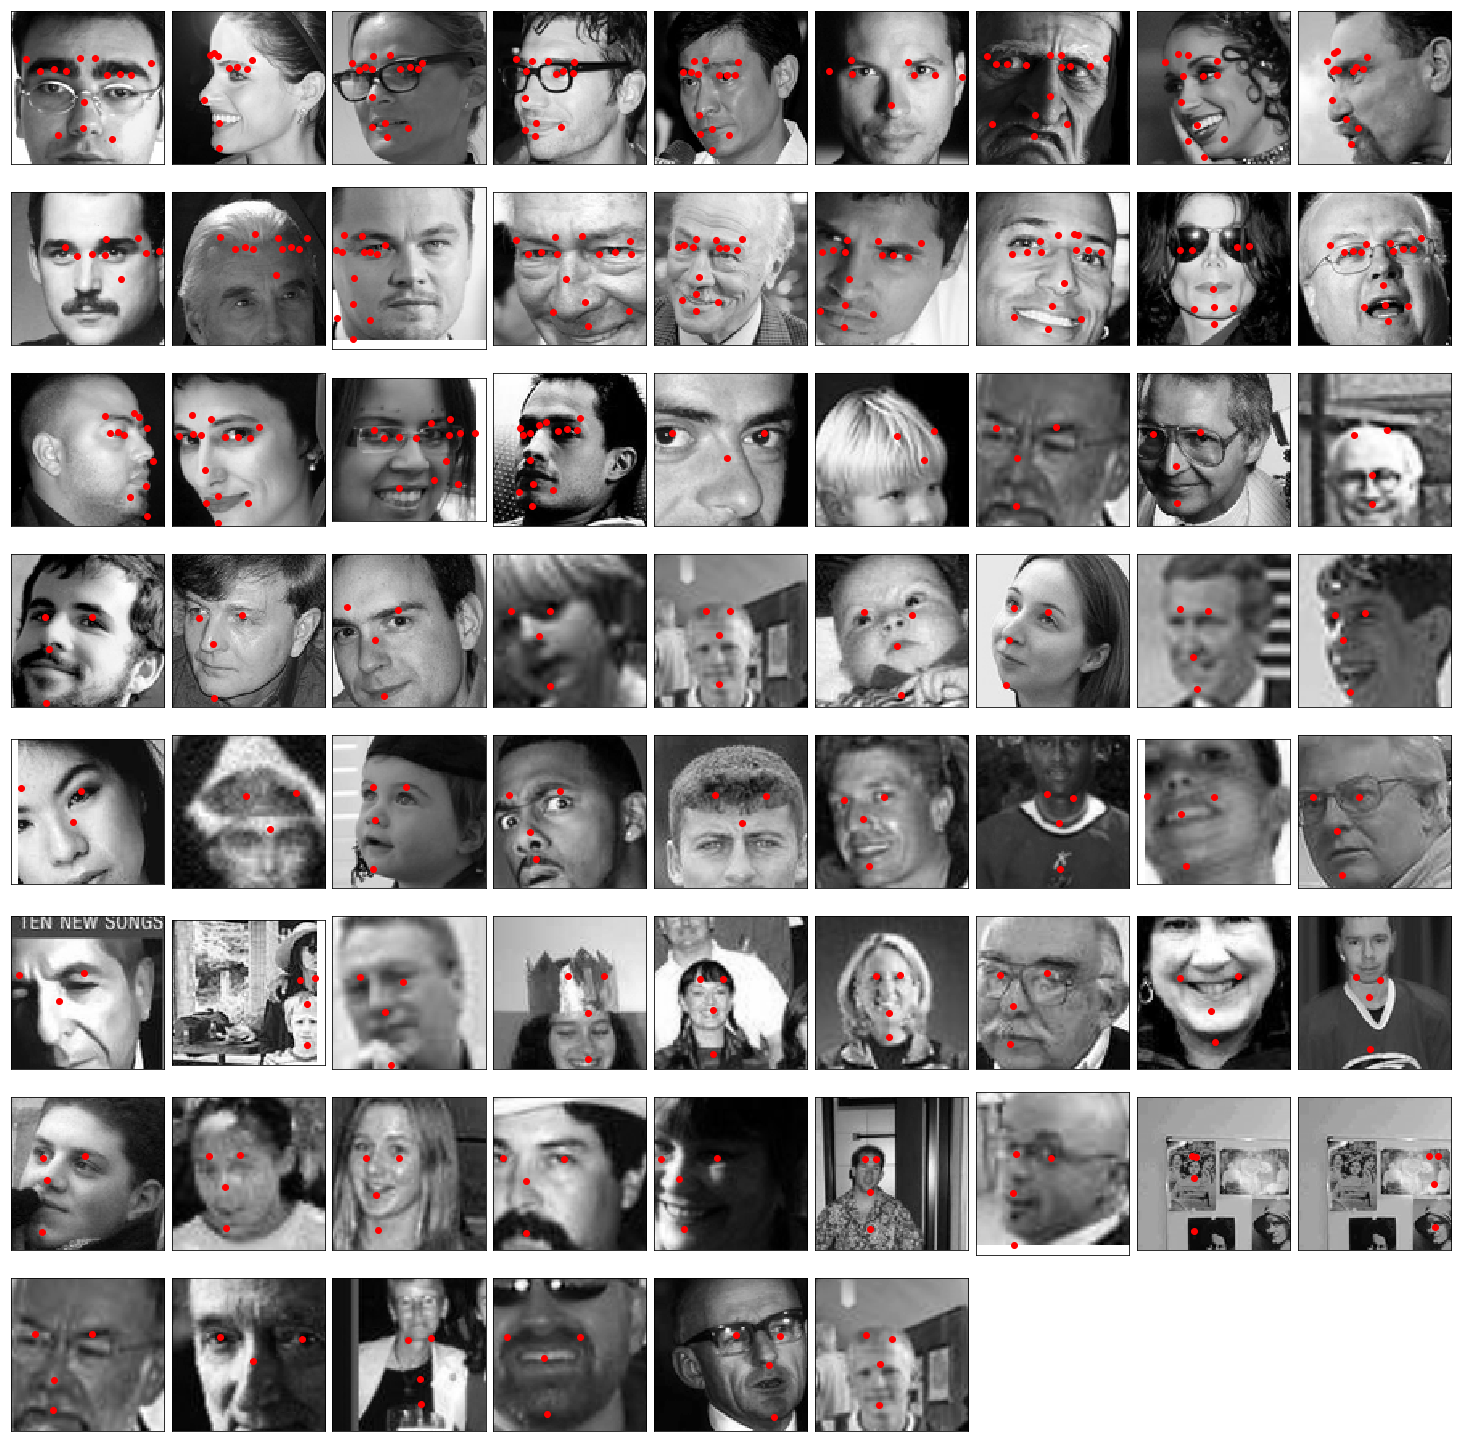

In [57]:
# hard code in flagged images
flagged = [1230, 1620, 1649, 1652, 1723, 1747, 1808, 1834, 1861, 1877, 1881, 1907, 1927, 1942, 1966, 1995,
           2036, 2096, 2175, 2191, 2199, 2244, 2289, 2453, 2484, 2533, 2562, 2629, 2664, 2700, 2787, 2818,
           2831, 2845, 2982, 3087, 3173, 3296, 3307, 3374, 3447, 3487, 3510, 3647, 3888, 4180, 4263, 4480,
           4482, 4490, 4601, 4717, 4786, 5117, 5795, 5952, 6082, 6271, 6315, 6405, 6407, 6492, 6493, 6569,
           6585, 6765, 6782, 6834, 6906]

# plot these images as a sanity check that they are in fact "bad" data
i = 0
rows = 8
cols = len(flagged)//rows + 1
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for index in flagged:
    ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    ax.imshow(train_data_raw[index].reshape(96,96), cmap='gray')
    ax.scatter(train_labels_raw[index][0::2] * 48 + 48, train_labels_raw[i][1::2] * 48 + 48, c='r')
    i += 1

In [58]:
# Delete these images from the data set forever
train_data_raw = np.delete(train_data_raw, flagged, 0)
train_labels_raw = np.delete(train_labels_raw, flagged, 0)

Because there are so many images with incomplete values, we now need to define another set with NA removed that will be used later on to train simple baseline models as well as predict the position of the missing labels for later training

In [59]:
# Dropping NAs
# drop bad data from original dataframe
train = train.drop(flagged)

# train_complete = no missing values
train_data_complete, train_labels_complete, _ = process_datasets(train, dropna=True)

In [60]:
### DON'T RUN THIS CELL MORE THAN ONCE WITHOUT RE-RUNNING PROCESS DATASETS! ###

# 20% of the data will go to dev
percent_to_dev = 0.2 

# Note the naming convention change.
# train_orig = with missing values

train_data_orig, dev_data_orig, train_labels_orig, dev_labels_orig = train_test_split(
    train_data_raw, train_labels_raw, test_size=percent_to_dev
)
train_data_complete, dev_data_complete, train_labels_complete, dev_labels_complete = train_test_split(
    train_data_complete, train_labels_complete, test_size=percent_to_dev
)

print("\nTrain data shape", train_data_orig.shape)
print("Dev data shape", dev_data_orig.shape)
print("Train labels shape", train_labels_orig.shape)
print("Dev labels shape", dev_labels_orig.shape)
print("\nTrain data no-missing-values shape", train_data_complete.shape)
print("Dev data no-missing-values shape", dev_data_complete.shape)
print("Train labels no-missing-values shape", train_labels_complete.shape)
print("Dev labels no-missing-values shape", dev_labels_complete.shape)

print("\nData Generation Finished")


Train data shape (5584, 96, 96, 1)
Dev data shape (1396, 96, 96, 1)
Train labels shape (5584, 30)
Dev labels shape (1396, 30)

Train data no-missing-values shape (1708, 96, 96, 1)
Dev data no-missing-values shape (427, 96, 96, 1)
Train labels no-missing-values shape (1708, 30)
Dev labels no-missing-values shape (427, 30)

Data Generation Finished


# Feature Engineering

To be sure our training set has enough variety to predict well on the observed edge cases, we expand the variety of our data set even more. We decided to create sets of images that were mirrored, altered contrast, blurred, and rotated as it seems these are the most prevalent gestures of the different faces. 

## Perform Augmentations

In [61]:
# We use the imgaug library to generate our new sets of images

def augment_images(data, labels, aug):
    
    data = data * 255
    aug_labels =[]
    seq_det = aug.to_deterministic()
    aug_data = seq_det.augment_images(data)
    
    keypoints_on_images = []
    
    for features in labels:
        keypoints = []
        
        for c in range(0, features.shape[0], 2):
            x = features[c]* 48 + 48
            y = features[c+1]* 48 + 48

            keypoints.append(ia.Keypoint(x=x, y=y))

        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=(96,96)))
    
    keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)    
        
    for keypoints_after in keypoints_aug:
        aug_labels_set = []
        
        for i, keypoint in enumerate(keypoints_after.keypoints):
            aug_labels_set.append((keypoint.x - 48) / 48)
            aug_labels_set.append((keypoint.y - 48) / 48)
                
        aug_labels.append(aug_labels_set)
        
    return aug_data/255, np.array(aug_labels)

# The imgaug library confuses the labels in the case of mirroring an image so we made our own custom method. 

def mirror_data(data, labels, features):
    '''This function flips the images and labels to their new columns
    Input data is numpy array of shape (X, 96, 96, 1)
    Input labels is numpy array of shape (X, 30)
    features is a list of column header strings
    '''
    
    # flip the images
    data_flipped = data[:, :, ::-1, :]
    
    # flip the labels
    labels_flipped = np.zeros(labels.shape)
    for idx in range(len(labels)):
        for i,s1 in enumerate(features):
            parts = s1.partition('_')
            if parts[0] == 'left' or parts[0] == 'right':
                coord = parts[-1]
            elif parts[0] == 'mouth':
                parts = s1.split('_', maxsplit=2)
                if 'corner' in parts[-1]:
                    coord = parts[-1]        
                elif 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            else:
                if 'x' in parts[-1]:
                    labels_flipped[idx,i] = labels[idx,i] * -1
                else:
                    labels_flipped[idx,i] = labels[idx,i]
            for j in range(i+1,len(features)-1):
                s2 = features[j]
                if coord in s2:
                    if 'x' in coord:
                        labels_flipped[idx,i] = labels[idx,j] * -1
                        labels_flipped[idx,j] = labels[idx,i] * -1
                    else:
                        labels_flipped[idx,i] = labels[idx,j]
                        labels_flipped[idx,j] = labels[idx,i]
                
    return data_flipped, labels_flipped

In [62]:
# mirror training and dev data
flipped_data, flipped_labels = mirror_data(
    train_data_orig, train_labels_orig, list(feature_dict.keys())
)

flipped_data_complete, flipped_labels_complete = mirror_data(
    train_data_complete, train_labels_complete, list(feature_dict.keys())
)

# Concatanating to make new set

# Note the new naming convention
# train_aug = augmented with missing values  
# train_aug_comp = augmented no missing values

train_data_aug = np.concatenate((train_data_orig,flipped_data), axis=0)
train_labels_aug =  np.concatenate((train_labels_orig, flipped_labels), axis=0)

train_data_aug_comp = np.concatenate((train_data_complete, flipped_data_complete),axis=0)
train_labels_aug_comp = np.concatenate((train_labels_complete,flipped_labels_complete),axis=0)

## Check Data Augmentation

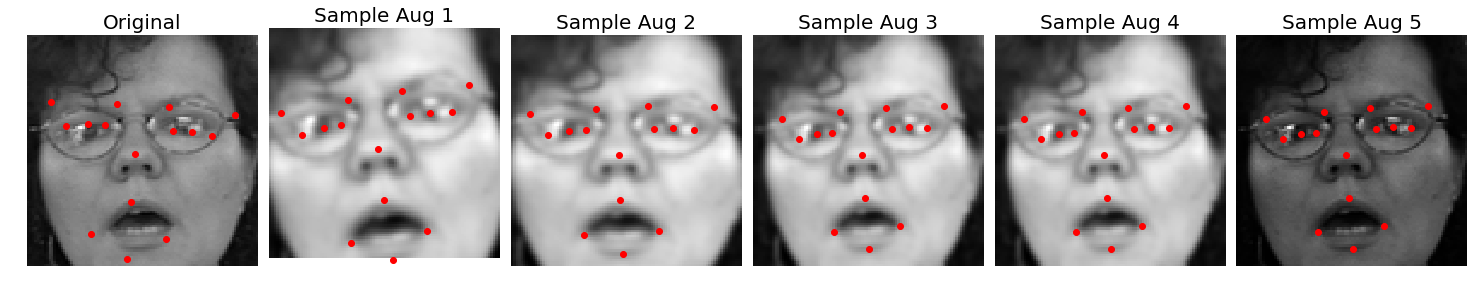

In [63]:
# We test applying 1,2 or 3 of blurring, contrast to the data. 
# We do this randomly to make sure everything is equally distributed.
# Note: We noticed this package does sometimes break (No GammaContrast) after install. Replace local folder with attached if happens.

aug_test = iaa.Sometimes(1,  iaa.SomeOf((1, 3), 
            [iaa.GammaContrast((0.25, 3)),
             iaa.GaussianBlur(sigma=1),
             iaa.Affine(rotate=(-10,10), scale={"x": (1.05, 1.2), "y": (1.05, 1.2)})
            ]                        
        )
    )

fig, axes = plt.subplots(1,6,figsize=(20,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


for i in range(6):
    test_data_aug, test_labels_aug = augment_images(
        np.expand_dims(train_data_aug_comp[0], axis=0), 
        np.expand_dims(train_labels_aug_comp[0], axis=0), aug_test
    )
    ax = axes[i]
    
    if i == 0:
        ax.set_title('Original', fontsize=20)
        ax.imshow(train_data_aug_comp[0].reshape(96,96), cmap='gray')
    else:
        ax.set_title('Sample Aug {i}'.format(i=i), fontsize=20)
        ax.imshow(test_data_aug.reshape(96,96), cmap='gray')
    
    ax.scatter(test_labels_aug[0][0::2] * 48 + 48, test_labels_aug[0][1::2] * 48 + 48, c='r')
    ax.axis('off')
    

In [64]:
# We apply the above to to 50% of the data so that there
# is an even amount of unmanipulated and manipulated data.

aug = iaa.Sometimes(0.5,  iaa.SomeOf((1, 3), 
            [iaa.GammaContrast((0.25, 3)),
             iaa.GaussianBlur(sigma=1),
             iaa.Affine(rotate=(-10,10), scale={"x": (1.05, 1.2), "y": (1.05, 1.2)})
            ]                        
        )
    )


train_data_aug, train_labels_aug = augment_images(train_data_aug, train_labels_aug, aug)
train_data_aug_comp, train_labels_aug_comp = augment_images(train_data_aug_comp, train_labels_aug_comp, aug)

Note again that the augmentations are applied to only 50% of the data so there may be some images above that are not augmented. 

# Establish Baseline

To begin our modeling, we select common supervised-learning regression algorithms such as linear regression, k-nearest neighbors, decision tree and random forest for baselines to compare our CNN to. The thought process behind choosing each one is described below. However, given existing literature, it seems CNN is the preferred way to solve problems of this nature. Therefore greater emphasis will be given for that technique. 

**Kaggle Output**

In [65]:
def predict_for_kaggle(model, test_data, filename):
    
    #Predict values for your chosen model
    try:
        pred = model.predict(test_data)
    except:
        pred = model
    
    # Get the list of required test points
    lookup = pd.read_csv('IdLookupTable.csv')
    
    #Match up the test points with the predicted values
    labelNums = {}
    for index, label in enumerate(train.columns.values):
        labelNums[label] = index
    lookup['FeatureNum'] = lookup.apply(
        lambda row: labelNums[row['FeatureName']], axis=1
    )
    lookup.Location =  np.minimum(
        96, np.maximum(0, pred[lookup.ImageId-1, lookup.FeatureNum]*48 + 48)
    )
    
    # save the rowid and the associated location to a csv
    lookup.to_csv(
        path_or_buf=filename, columns=['RowId','Location'], index=False
    )
    
    return pred

## Simple Models

To begin our modeling, in a similar fashion to Shi (2017), we select common supervised-learning regression algorithms such as linear regression, k-nearest neighbors, decision tree and random forest for baselines to compare our CNN to. The thought process behind choosing each one is described below. However, given existing literature, it seems CNN is the preferred way to solve problems of this nature. Therefore greater emphasis will be given for that technique. The choice of these algorithms is also partially inspired by https://scikit-learn.org/stable/auto_examples/plot_multioutput_face_completion.html#sphx-glr-auto-examples-plot-multioutput-face-completion-py 

We start off by seeing how different the average location is for each feature versus the different images themselves. This gives a "no work done" baseline to compare future results to.

In [88]:
# As a simple test, we want to look at the average of all the features and what the error of that would be. 
# We use the complete set to avoid issues with incomplete values. 

avg_dict = {}

avg_position = np.mean(train_labels_aug_comp, axis=0)
predictions = np.ones(train_labels_aug_comp.shape) * avg_position
train_mse = np.sqrt(mean_squared_error(train_labels_aug_comp, predictions)) * 48
avg_dict['Training Average'] = [round(train_mse,2), None, None, predictions]

predict_for_kaggle(predictions, test_data, 'average_result_kaggle.csv')

print ('The RMSE error when predicting average value for each label:', mse)

The RMSE error when predicting average value for each label: 3.7235639845060655


The following code will model the data using the chosen baseline models. The models will run pre-optimized as the grid search portions of the code were done prior to assignment submission. 

In [94]:
# More simple baselines
regressors = {
    'LinearRegression': LinearRegression(normalize = True),
    'DecisionTree': DecisionTreeRegressor(random_state=0, min_samples_split=2),
    'RandomForest': RandomForestRegressor(random_state=0, min_samples_split=2, n_estimators=6),
    'NearestNeighbors': KNeighborsRegressor(weights='uniform', metric='euclidean')
} 

# Optimization Parameters

parameters = {
    'RandomForest': {'n_estimators': [6,8,10,12]}, 
    'DecisionTree': {'min_samples_split': [2,3,4]},
    'NearestNeighbors':  {'weights': ['uniform','distance'], 'metric': ['euclidean','manhattan','minkowski']}, 
    'LinearRegression': {'fit_intercept': [True, False], 'normalize':[True, False]}
}

rmse_scorer = make_scorer(mean_squared_error)

def model_training(dict_name, model, parameters, train_data, labels, dev_data, dev_labels, test_data, grid = False):
    X = train_data.reshape(-1, 96**2)
    Y = labels
    
    if grid == True:        
        grid_obj = GridSearchCV(model, parameters, scoring=rmse_scorer)
        grid_obj = grid_obj.fit(X, Y)
        
        print(grid_obj.best_params_)
        
        regressor = grid_obj.best_estimator_
        start=datetime.now()
        regressor.fit(X, Y)
        runtime = datetime.now() - start
        predictions = regressor.predict(X)
        
        train_mse = np.sqrt(mean_squared_error(Y, predictions)) * 48

        Z = dev_data.reshape(-1, 96**2)

        predictions = regressor.predict(Z)
        dev_mse = np.sqrt(mean_squared_error(dev_labels, predictions)) * 48
        
        predict_for_kaggle(regressor, test_data.reshape(-1, 96**2), dict_name +'_kaggle.csv')
    
    else:
    
        start=datetime.now()
        model.fit(X,Y)
        runtime = datetime.now() - start

        predictions = model.predict(X)
        train_mse = np.sqrt(mean_squared_error(Y, predictions)) * 48

        r2_train = model.score(X, Y)
        
        Z = dev_data.reshape(-1, 96**2)

        predictions = model.predict(Z)
        dev_mse = np.sqrt(mean_squared_error(dev_labels, predictions)) * 48
        
        r2_dev = model.score(Z, dev_labels)
        
        predict_for_kaggle(model, test_data.reshape(-1, 96**2), dict_name +'_kaggle.csv')
    
    return [round(train_mse,2), round(dev_mse,2), round(runtime.seconds,2), predictions, round(r2_train,2), round(r2_dev,2)]


In [95]:
def train_basic_models(which_set, avg_dict, train_data, train_labels, dev_data, dev_labels, test_data, grid = False):
    if which_set == 'complete':
        print ('This is with the complete set')
    elif which_set == 'complete_aug':
        print ('This is with the complete_aug set')
    
    basic_models = {}
    
    for k,v in regressors.items():
        p = parameters[k]
        
        if which_set == 'complete':
            dict_name = k + '_complete'
        elif which_set == 'complete_aug':
            dict_name = k + '_complete_aug'
        
        result = model_training(dict_name, v, p, train_data, train_labels, dev_data, dev_labels, test_data, grid)
        
        basic_models[dict_name] = result
        
        print('\n', k,':\n',
              'Training RMSE=', result[0],
              'Train R2=', result[4],
              'Dev RMSE=', result[1],
              'Dev R2=', result[5],
              'Train Time=', result[2]
             )

    img_idx = 2
    img = train_data_complete[img_idx].reshape(96,96)

    fig, axes = plt.subplots(1,len(basic_models) + 1,figsize=(15,15))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    print ('\nResults Below. Red = Actual Labels  Blue = Predicted Labels\n')
    
    ax = axes[0]
    ax.imshow(img, cmap='gray')
    ax.scatter(train_labels_complete[img_idx][0::2] * 48 + 48, train_labels_complete[img_idx][1::2] * 48 + 48, c='r')
    ax.scatter(avg_dict['Training Average'][3][img_idx][0::2] * 48 + 48, avg_dict['Training Average'][3][img_idx][1::2] * 48 + 48, c='b')
    ax.axis('off')
    ax.set_title('Training Average', fontsize=11)
    
    for i,(k,v) in enumerate(basic_models.items()):
        ax = axes[i+1]
        ax.imshow(img, cmap='gray')
        ax.scatter(train_labels_complete[img_idx][0::2] * 48 + 48, train_labels_complete[img_idx][1::2] * 48 + 48, c='r')
        ax.scatter(v[3][img_idx][0::2] * 48 + 48, v[3][img_idx][1::2] * 48 + 48, c='b')
        ax.axis('off')
        ax.set_title(k, fontsize=11)
        
    return basic_models

This is with the complete set

 LinearRegression :
 Training RMSE= 0.0 Train R2= 1.0 Dev RMSE= 2.56 Dev R2= 0.3 Train Time= 4

 DecisionTree :
 Training RMSE= 0.0 Train R2= 1.0 Dev RMSE= 3.39 Dev R2= -0.23 Train Time= 21

 RandomForest :
 Training RMSE= 1.2 Train R2= 0.86 Dev RMSE= 2.47 Dev R2= 0.35 Train Time= 77

 NearestNeighbors :
 Training RMSE= 1.96 Train R2= 0.62 Dev RMSE= 2.36 Dev R2= 0.4 Train Time= 0

Results Below. Red = Actual Labels  Blue = Predicted Labels



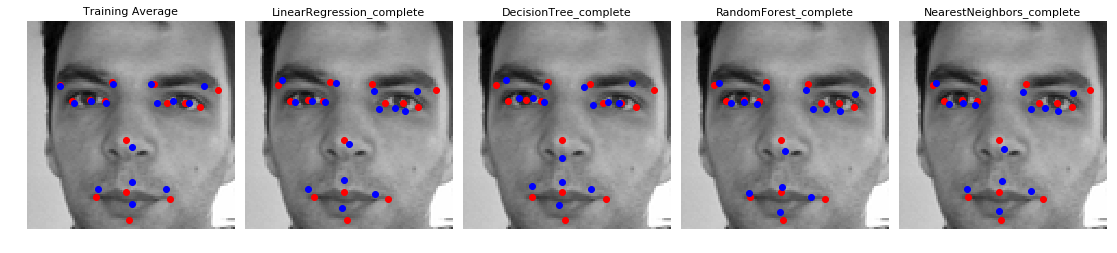

In [96]:
results_comp = train_basic_models('complete', avg_dict, train_data_complete, train_labels_complete, dev_data_complete, dev_labels_complete, test_data)

This is with the complete_aug set

 LinearRegression :
 Training RMSE= 0.0 Train R2= 1.0 Dev RMSE= 221.61 Dev R2= -5268.35 Train Time= 27

 DecisionTree :
 Training RMSE= 0.0 Train R2= 1.0 Dev RMSE= 3.74 Dev R2= -0.5 Train Time= 59

 RandomForest :
 Training RMSE= 1.5 Train R2= 0.84 Dev RMSE= 2.58 Dev R2= 0.29 Train Time= 222

 NearestNeighbors :
 Training RMSE= 2.57 Train R2= 0.52 Dev RMSE= 2.4 Dev R2= 0.38 Train Time= 2

Results Below. Red = Actual Labels  Blue = Predicted Labels



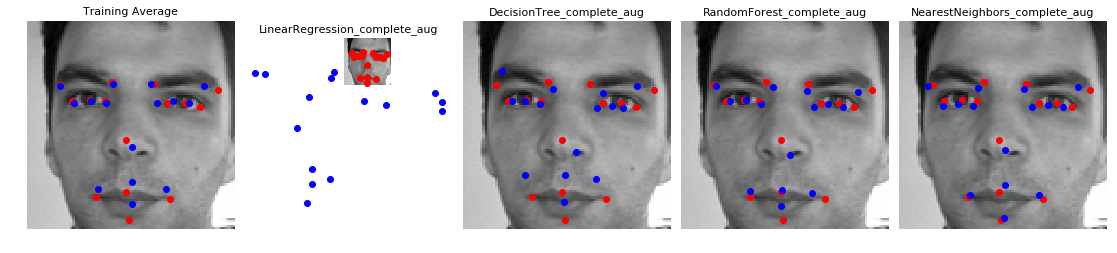

In [97]:
results_comp_aug = train_basic_models('complete_aug', avg_dict, train_data_aug_comp, train_labels_aug_comp, dev_data_complete, dev_labels_complete, test_data)

In [89]:
def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

result_dict = merge_dicts(avg_dict, results_comp, results_comp_aug)

### Overall Results

Without augmentations, it seems that kNN performs the best in terms of lowest RMSE for the dev data followed by Random Forest, Linear Regression, and then Decision Trees. This isn't surprising as kNN essentially assigns the kth point by it's closest values as described below. 

Comparing Decision Trees and Random Forests, a single Decision Tree performs the worst but after aggregating to a Random Forest, the algorithm performs a lot better likely due to the model generalzing much more.

When looking at the augmented result, kNN and Random Forest retain their performance ranking however linear regression performs much more poorly. This is likely due to the manipulated images being introduced.

### Linear Regression

**Rational:** Linear regression essentially minimizes the squared error distance between actual and predicted values. This was picked because of its simplicity and it would be interesting to gauge the performance of a classical regressor.

**Weakness:** With a smaller training set size, the RMSE is comparable to that of the other algorithms however once the training set increases, the RMSE gets much worse. This likely means that the algorithm performs poorly with extreme variation in the labels and the images they map to. This is not unexpected as linear models assume a linear relationship between independent variables and the dependent variables. This would not apply to facial positions especially if they are not all full frontal shots. Therefore, it is likely not reliable as an algorithm moving forward.

**Future:** There are other linear modeling techniques such as Lasso and ElasticNet which add regularization terms that often are used to reduce overfitting. The results would be interesting to see however the assumption of a linear relationship still applies. Also the choosing of the regularization parameter would warrant some deep investigation.

### Random Forest/Decision Tree

**Rational:** A decision tree is a non-parametric supervised learning method that predicts the value of a target variable by establishing decision rules inferred from the data features. Random Forests typically reduce variance by training on different samples of the data. Another way that it reduces overfitting is that it uses a random subset of features each time. This allows the overall algorithm to generalize better.

**Weakness:** By itself, the decision tree algorithm seemed to perform the worst. It could be that we have overfitted the model since decisions can be very complex and is very sensitive to small variations. Tree are also known to ignore the correlation between features, which is highly the case in this experiment. For instance, knowing the position of one eye can often tell you the position of the other eye.

**Future:** Although there was a grid-search performed, further hyperparameter tuning to improve performance include pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth may be helpful in generalizing the model further.

### KNN 

**Rational:** We pick kNN because facial features are all approximately at the same location on the face i.e left eye is on the upper left, right eye is on the upper right, nose is in the middle, etc. kNN works by assigning a query point as an average of those of its closest neighbors. Therefore, given a set of images, we figured kNN should be able to compute which pixels is generally associated with the eye area, the nose area, etc.

**Weakness:** One potential weakness of this algorithm may be images where the face located off center. For example, if an image has a face translated to the right, then it may mistake the left eye on the image for a right eye

**Future:** One of the corner stones of knn is the idea of distance and how that is defined. We have found that Euclidean is better than the default Minknowski distance set by sklearn however the use of correlation might be more appropriate since as described above, the position of features on a face are all correlated in some sense. In other studies, Chi square distance also seems to perform well. Both of these would be worth engineering and exploring in the future. 

# Convolutional Neural Network

## Building the CNN

In order to establish what is considered a "successful" CNN, we establish a few metrics. First, we wish to track how long each model takes to run.

In [27]:
# building a time callback to track total runtime
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

Since most of the images contain one or more missing labels, and the built-in loss functions are not equipped to handle NA values, it is necessary to build a custom loss function to handles these data. The premise is to calculate the mean squared error only of points for which the ground truth is known. For completely labelled images, this is the same as the usual mean squared error. For an image with only $m$ labels, this is calculated as:
$$\text{loss}\left(y_\text{true},y_\text{pred}\right) =  
\text{loss}\left(
\begin{bmatrix}
\text{label 1} \\
\text{label 2} \\
\text{NA} \\
\text{NA} \\
\text{label 5} \\
\text{label 6} \\
\text{NA} \\
\text{NA} \\
\vdots \\
\text{label 30}
\end{bmatrix}
,
\begin{bmatrix}
\text{prediction 1} \\
\text{prediction 2} \\
\text{prediction 3} \\
\text{prediction 4} \\
\text{prediction 5} \\
\text{prediction 6} \\
\text{prediction 7} \\
\text{prediction 8} \\
\vdots \\
\text{prediction 30}
\end{bmatrix}
\right)
= \frac{1}{m}\cdot\begin{pmatrix}
\text{(error 1)}^2+ \\
\text{(error 2)}^2+ \\
\\
\\
\text{(error 5)}^2 +\\
\text{(error 6)}^2 +\\
\\
\\
\vdots \\
\text{(error 30)}^2
\end{pmatrix}
$$

In [28]:
# building a custom loss function to handle NAs
def mean_squared_error_with_missing(y_true, y_pred):
    
    # figure out which labels are present
    present = tf.logical_not(tf.is_nan(y_true))
    
    # select only those labels
    present_labels_true = tf.boolean_mask(y_true, present)
    present_labels_pred = tf.boolean_mask(y_pred, present)
    
    # compute mean squared error
    loss = tf.math.reduce_mean(tf.math.squared_difference(present_labels_true,present_labels_pred))
    
    return loss

**Build the model**

(-0.5, 530.5, 1179.5, -0.5)

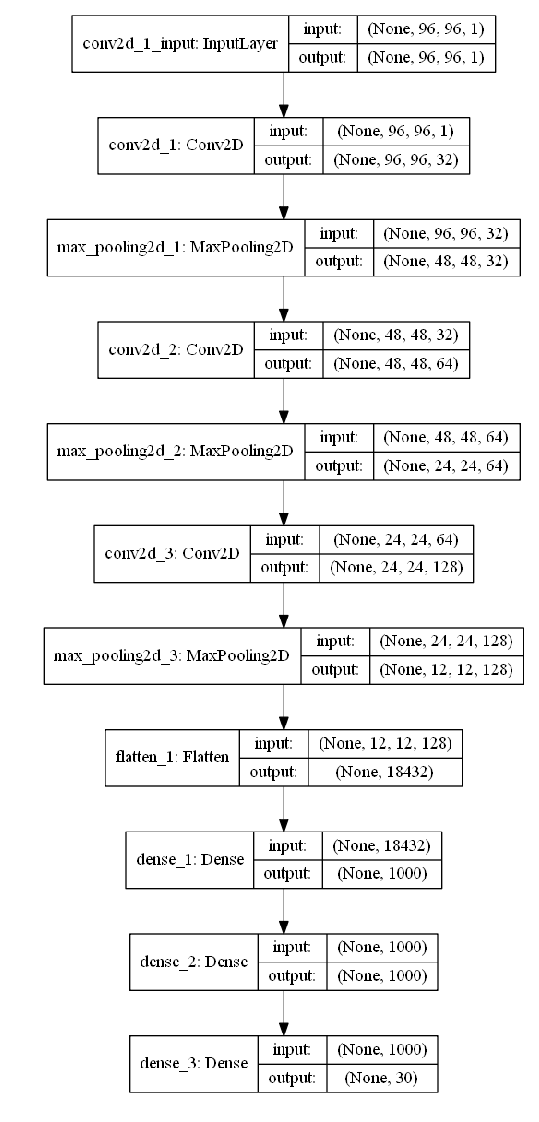

In [29]:
mod = plt.imread('model.png')
fig = plt.figure(figsize=(10,20), frameon=False)
plt.imshow(mod)
plt.axis('off')

**Parameter and Hyper-parameter selection:**

The Convolutional Neural Network (CNN) has many parameters to choose to build the model. We first need to determine how many layer stacks the model should have. Each layer stack should contain, at a minimum, a convolutional layer and a pooling layer. You can also choose to add a dropout layer at each stack, to help avoid overfitting on the training set.  For each convolutional layer, we need to determine the shape of the convolutional kernel, as well the shape of the pooling kernel. After the convolutional layer stack, the output needs to be flattened and we need to determine the number of dense layers to send it through before generating the output. Again we can choose to add dropout layers here or not. After we have decided on the shape our network will take, we need to determine the optimizer to use, and the loss function. The optimizer comes with its own set of hyperparameters, the most important of which is the initial learning rate according to Bengio.

**Optimizer:**  
Per Bengio, for stochastic gradient descent (SGD) optimization, "The optimal learning rate is usually close to the largest learning rate that does not cause divergence of the training criterion." His suggestion is to start with a large learning rate and if the training criterion diverges, decrease the learning rate by a factor of 3. Due to hardware memory limitations, we were unable to carry out full hyperparameter tuning via grid search. So rather than search for the optimal SGD learning rate, we chose to use an adaptive optimizer called Adam which converges much faster than standard SGD. Adam is an adaptation/enhancement to SGD. Whereas SGD uses a single learning rate for all weight updates and does not update the learning rate during training, the Adam optimizer "calculates an exponential moving average of the gradient and the squared gradient." The hyperparameters beta1 and beta2 control the decay rates of these moving averages. Because the authors of the Adam optimizer performed hyperparameter tuning on a similar convolutional neural net built for prediction on the MNIST data set, we used the default values of the Adam optimizer which are currently set to the optimal values determined by the authors.

**Number of Layers:**  
Again according to Bengio, "the optimal number layers can be determine by simply adding layers until the error does not improve anymore." As we were using the Daniel Nouri tutorial as a guide to building the CNN, we started with three convolutional/pooling layer pairs in our CNN. We tested 4 and 5 layer pairs as well which gave little to no improvement in the loss on the validation data, but did increase the training time significantly, so we decided on three layer pairs for the default value of the model. 

**Number of filters:**  
Each filter in a convolutional layer can be thought of as a single feature detector. In the initial layer, the filters will be able to detect simple geometric patterns such as a lines or curves. As we go deeper in the network, the feature detectors can become more sophisticated. Since we want to predict the position of 15 facial keypoints varying in shape and size and orientation, we need to have enough feature detectors by the last layer to handle a large variety of features. We tried various combinations of factors of 2 for the number of filters in each layer, with the number of filters multiplying by 2 at each layer. After some trial and error, we settled on 32, 64, 128 filters for convolutional layers 1, 2, and 3 respectively. 

**Pooling layers:**  
The pooling layers determine the factor by which you downscale your data after each convolutional layer. We chose to simply use pooling kernels of (2,2) with a stride of (2,2) so that our output shape at each layer was easy to keep track of

**Number of Dense layers and Dense layer nodes:**  
Admittedly, we spent more of our time tuning the parameters in the convolutional stack than in the dense layer section of the model, but we did test some variations ranging from 1 layer with 100 nodes to 3 layers of 2000 nodes and ended up settling on 2 layers with 1000 nodes each for our default model values.


In [30]:
def build_CNN(
    num_ConvLayers=3, 
    num_DenseLayers=2,
    filters=[32,64,128],
    kernels=[(3,3),(3,3),(3,3)], 
    pools=[(2,2),(2,2),(2,2)], 
    dense_nodes=[1000,1000], 
    optimizer='Adam', 
    dropout=None,
    input_shape=(96,96,1),
    loss=mean_squared_error_with_missing
):
    '''This function builds a CNN model
    num_ConvLayers --> is the number of convolutional layer groups where 
    each group contains a convolutional layer, a pooling layer, and an
    optional dropout layer
    
    num_DenseLayers --> is the number of dense layers after flattening
    the convolutional output
    
    filters --> a list of the number of filters used in each
    convolutional layer specified in num_ConvLayers
    
    kernels --> a list of the kernel size to use in each convolutional
    layer specified in num_ConvLayers
    
    pools --> a list of the kernel size to use in each pooling layer
    specified in num_ConvLayers
    
    dense_nodes --> a list of the number of units in each dense layer
    specified in num_DenseLayers
    
    dropout --> optional, a list of the dropout rates at each 
    convolutional layer
    
    input_shape --> the shape of the input data
    '''
    # define a Sequential model
    model = Sequential()
    
    # add convolutional layer groups
    for i in range(num_ConvLayers):
        model.add(Conv2D(
            filters=filters[i],
            kernel_size=kernels[i],
            strides=(1,1),
            padding='same',
            activation='relu',
            input_shape=input_shape
        ))
        model.add(MaxPooling2D(
            pool_size=pools[i],
            strides=None
        ))
        
        # add dropout layers if specified
        if dropout:
            model.add(Dropout(rate=dropout[i]))
    
    # flatten the convolutional layers
    model.add(Flatten())
    
    # add the dense layers
    for j in range(num_DenseLayers):
        model.add(Dense(
            units=dense_nodes[j],
            activation='relu'
        ))
        
    # create the output layer
    model.add(Dense(units=30))
    
    # compile the model
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

**Train the model**

In [31]:
def train_model(
    model, 
    train_data, train_labels, 
    dev_data=None, dev_labels=None,
    batch_size=32,
    verbose=1,
    epochs=10
):
    time_callback = TimeHistory()
    hist = keras.callbacks.History()
    if not dev_data is None:
        model.fit(
            train_data, train_labels, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_data=(dev_data, dev_labels),
            verbose=verbose,
            callbacks=[hist, time_callback]
        )
    else:
        model.fit(
            train_data, train_labels, 
            batch_size=batch_size,
            epochs=epochs, 
            validation_split=0.2,
            verbose=verbose,
            callbacks=[hist, time_callback]
        )
    print('\nRMS error on validation set:', np.sqrt(hist.history['val_loss'][-1]) * 48)
    print('Total runtime (minutes):', round(np.sum(time_callback.times) / 60, 2))
    
    return hist, time_callback

###  Running CNN
the below table contains a layout of our training plan. The 0th model will be trained on the complete data set (no missing values) for performance comparison against the simple baseline models. The first true model will be trained on the original dataset with missing values and no augmentations applied. The second model will use the original dataset with all augmentations applied. The third model will use the augmented data with NAs filled by 2-layer NN predictions. The fourth model will be the same as model 3 but we will utilize dropout layers to prevent overfitting

<table> 
<tr>
<th> Model Name </th> <th> Model Parameters </th> <th> Data </th> <th> Training Criteria </th>
</tr>
<tr>
<td> Model 0a </td> <td> Default </td> <td> Complete Data </td> <td> 50 epochs </td>
</tr>
    <tr>
<td> Model 0b </td> <td> Default </td> <td> Complete Data + Augmentations </td> <td> 50 epochs </td>
</tr>
    <tr>
<td> Model 1 </td> <td> Default </td> <td> Original Data </td> <td> 50 epochs </td>
</tr>
    <tr>
<td> Model 2 </td> <td> Default </td> <td> Original Data + Augmentations </td> <td> 50 epochs </td>
</tr>
    <tr>
<td> Model 3 </td> <td> Default </td> <td> Aug. data, NAs filled by 2-layer NN predictions </td> <td> 50 epochs </td>
</tr>
    <tr>
<td> Model 4 </td> <td> Add dropout layers </td> <td> Aug. data, NAs filled by 2-layer NN predictions </td> <td> 50 epochs </td>
</tr>
    <tr>
</tr>
</table>

#### Model 0

In [ ]:
model0a = build_CNN()

In [ ]:
# train the model
hist0a, runtime0a = train_model(
    model0a, train_data_complete, train_labels_complete, 
    dev_data_complete, dev_labels_complete, epochs=50
)

# save off the history
history0a = pd.DataFrame(hist0a.history)
history0a.to_csv('history_model0a.csv')

# predict on test data and format for kaggle submission
pred0a = predict_for_kaggle(model0a, test_data, 'kaggle_model0a.csv')

# store the results
result_dict['CNN Model0a'] = [
    round(np.sqrt(hist0a.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist0a.history['val_loss'][-1]) * 48,2),
    round(np.sum(runtime0a.times),2)
]
df = pd.DataFrame(result_dict)
with open('results.csv','a') as f:
    df.to_csv(f, header=False)

**Sample Output:**  
Epoch 45/50
1708/1708 [==============================] - 5s 3ms/step - loss: 8.1322e-05 - val_loss: 8.6889e-04  
Epoch 46/50
1708/1708 [==============================] - 5s 3ms/step - loss: 7.1458e-05 - val_loss: 8.5436e-04  
Epoch 47/50
1708/1708 [==============================] - 5s 3ms/step - loss: 5.9298e-05 - val_loss: 8.5960e-04  
Epoch 48/50
1708/1708 [==============================] - 5s 3ms/step - loss: 6.7656e-05 - val_loss: 8.7716e-04  
Epoch 49/50
1708/1708 [==============================] - 5s 3ms/step - loss: 9.0617e-05 - val_loss: 9.2394e-04  
Epoch 50/50
1708/1708 [==============================] - 5s 3ms/step - loss: 9.3611e-05 - val_loss: 8.6582e-04

RMS error on validation set: 1.412393725162649  
Total runtime (minutes): 4.62

In [ ]:
model0b = build_CNN()

In [ ]:
# train the model
hist0b, runtime0b = train_model(
    model0b, train_data_aug_comp, train_labels_aug_comp, 
    dev_data_complete, dev_labels_complete, epochs=50
)

# save off the history
history0b = pd.DataFrame(hist0b.history)
history0b.to_csv('history_model0b.csv')

# predict on test data and format for kaggle submission
pred0b = predict_for_kaggle(model0b, test_data, 'kaggle_model0b.csv')

# store the results
result_dict['CNN Model0b'] = [
    round(np.sqrt(hist0b.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist0b.history['val_loss'][-1]) * 48,2),
    round(np.sum(runtime0b.times),2)
]
df = pd.DataFrame(result_dict)
with open('results.csv','a') as f:
    df.to_csv(f, header=False)

**Sample Output:**  
Epoch 45/50
3416/3416 [==============================] - 11s 3ms/step - loss: 0.0056 - val_loss: 0.0038  
Epoch 46/50
3416/3416 [==============================] - 11s 3ms/step - loss: 0.0055 - val_loss: 0.0034  
Epoch 47/50
3416/3416 [==============================] - 11s 3ms/step - loss: 0.0052 - val_loss: 0.0033  
Epoch 48/50
3416/3416 [==============================] - 11s 3ms/step - loss: 0.0049 - val_loss: 0.0031  
Epoch 49/50
3416/3416 [==============================] - 11s 3ms/step - loss: 0.0051 - val_loss: 0.0033  
Epoch 50/50
3416/3416 [==============================] - 11s 3ms/step - loss: 0.0047 - val_loss: 0.0029

RMS error on validation set: 2.5735120600853074  
Total runtime (minutes): 8.85

#### Model 1

In [ ]:
model1 = build_CNN()

In [ ]:
# train the model
hist1, runtime1 = train_model(
    model1, train_data_orig, train_labels_orig, 
    dev_data_orig, dev_labels_orig, epochs=50
)

# save off the history
history1 = pd.DataFrame(hist1.history)
history1.to_csv('history_model1.csv')

# predict on test data and format for kaggle submission
pred1 = predict_for_kaggle(model1, test_data, 'kaggle_model1.csv')

# store the results
result_dict['CNN Model1'] = [
    round(np.sqrt(hist1.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist1.history['val_loss'][-1]) * 48,2),
    round(np.sum(runtime1.times),2)
]

**Sample Output:**  
Epoch 45/50
5584/5584 [==============================] - 18s 3ms/step - loss: 1.5227e-04 - val_loss: 0.0013  
Epoch 46/50
5584/5584 [==============================] - 18s 3ms/step - loss: 1.5073e-04 - val_loss: 0.0013  
Epoch 47/50
5584/5584 [==============================] - 18s 3ms/step - loss: 1.4227e-04 - val_loss: 0.0013  
Epoch 48/50
5584/5584 [==============================] - 18s 3ms/step - loss: 1.4169e-04 - val_loss: 0.0012  
Epoch 49/50
5584/5584 [==============================] - 18s 3ms/step - loss: 1.4197e-04 - val_loss: 0.0013  
Epoch 50/50
5584/5584 [==============================] - 18s 3ms/step - loss: 1.4347e-04 - val_loss: 0.0012

RMS error on validation set: 1.6878204212283365  
Total runtime (minutes): 14.79

We could try running this for longer, but the way the validation loss levels off even as the training loss continues to shrink shows that the model is overfitting. This is unsurprising given the small size of our data set, and the large number of parameters. For better results, we should next try the full (unaugmented) data set and see how it fares.

#### Model 2

In [ ]:
model2 = build_CNN()

In [ ]:
# train the model
hist2, runtime2 = train_model(
    model2, train_data_aug, train_labels_aug, 
    dev_data_orig, dev_labels_orig, epochs=50
)

# save off the history
history2 = pd.DataFrame(hist2.history)
history2.to_csv('history_model2.csv')

# predict on test data and format for kaggle submission
pred2 = predict_for_kaggle(model2, test_data, 'kaggle_model2.csv')

# store the results
result_dict['CNN Model2'] = [
    round(np.sqrt(hist2.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist2.history['val_loss'][-1]) * 48,2), 
    round(np.sum(runtime2.times),2)
]
df = pd.DataFrame(result_dict)
with open('results.csv','a') as f:
    df.to_csv(f, header=False)

**Sample Output:**  
Epoch 45/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0036 - val_loss: 0.0031  
Epoch 46/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0035 - val_loss: 0.0030  
Epoch 47/50
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0035 - val_loss: 0.0030  
Epoch 48/50
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0034 - val_loss: 0.0031  
Epoch 49/50
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0034 - val_loss: 0.0030  
Epoch 50/50
11168/11168 [==============================] - 35s 3ms/step - loss: 0.0033 - val_loss: 0.0029

RMS error on validation set: 2.6039755262530617  
Total runtime (minutes): 28.81

This did significantly better and the validation loss was still improving alongside the training loss at the end of ten epochs. Given this continued improvement, it would be worth running this for longer.

### Predict missing values
As previously observed, some labels appear much more frequently than others. There are around 7000 images which contain x and y coordinate labels for the left and right eye centers, the tip of the nose, and the upper lip; while only around 2000 contain the full set of 30 coordinate labels. However, given knowledge about these four facial landmarks, it is possible to make an educated guess about the remaining eleven. The following short neural net trains on the completely labelled images, using the four common points to predict the full set of labels.

Replacing missing values with these inferred labels gives a new "ground" truth, against which we retrain our model.

In [32]:
basicNN = Sequential()
basicNN.add(Dense(units=1000,activation='relu'))
basicNN.add(Dense(units=1000,activation='relu'))
basicNN.add(Dense(units=1000,activation='relu'))

# create the output layer
basicNN.add(Dense(units=30))

# compile the model
basicNN.compile(loss=mean_squared_error_with_missing, optimizer='Adam')

In [33]:
NN_hist, NN_time = train_model(
    basicNN,
    train_labels_aug_comp[:,[0,1,2,3,20,21,28,29]], train_labels_aug_comp,
    epochs=20
)

Train on 2732 samples, validate on 684 samples
Epoch 1/20
2732/2732 [==============================] - 5s 2ms/step - loss: 0.0093 - val_loss: 0.0022
Epoch 2/20
2732/2732 [==============================] - 4s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 4/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 6/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 8/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/20
2732/2732 [==============================] - 4s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/20
2732/2732 [============

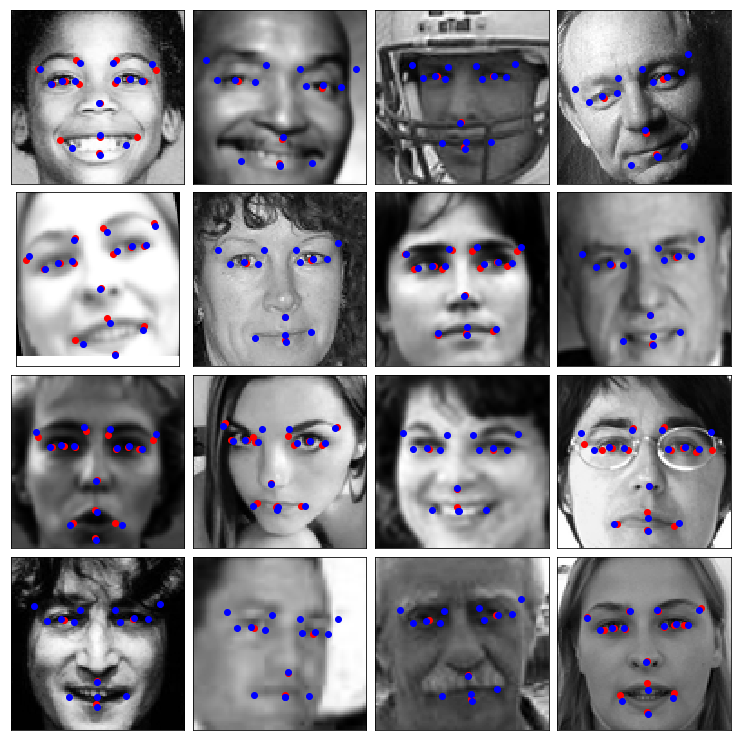

In [34]:
idx = np.random.randint(0, len(train_data_aug), 16)
data_sample = train_data_aug[idx, :, :, :]

pred = basicNN.predict(train_labels_aug[:,[0,1,2,3,20,21,28,29]])

label_sample = pred[idx, :]
label_sample_true = train_labels_aug[idx, :]

plot_sample(data_sample, label_sample_true, labels2=label_sample)

In [35]:
train_labels_full = train_labels_aug.copy()
for i in range(train_labels_full.shape[1]):
    for j,v in enumerate(train_labels_full[:,i]):
        if np.isnan(v):
            train_labels_full[j,i] = pred[j,i]

#### Model 3

In [ ]:
# augment some data or change a parameter
model3 = build_CNN()

Testing against augmented dev data with missing values

In [ ]:
# train the model
hist3, runtime3 = train_model(
    model3, train_data_aug, train_labels_full, 
    dev_data_orig, dev_labels_orig, epochs=50
)

# save off the history
history3 = pd.DataFrame(hist3.history)
history3.to_csv('history_model3.csv')

# predict on test data and format for kaggle submission
pred3 = predict_for_kaggle(model3, test_data, 'kaggle_model3.csv')

# store the results
result_dict['CNN Model3'] = [
    round(np.sqrt(hist3.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist3.history['val_loss'][-1]) * 48,2), 
    round(np.sum(runtime3.times),2)
]
df = pd.DataFrame(result_dict)
with open('results.csv','a') as f:
    df.to_csv(f, header=False)

**Sample Output:**  
Epoch 45/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0032 - val_loss: 0.0028  
Epoch 46/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0031 - val_loss: 0.0028  
Epoch 47/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0031 - val_loss: 0.0026  
Epoch 48/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0030 - val_loss: 0.0029  
Epoch 49/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0030 - val_loss: 0.0026  
Epoch 50/50
11168/11168 [==============================] - 34s 3ms/step - loss: 0.0029 - val_loss: 0.0027

RMS error on validation set: 2.496227290236337  
Total runtime (minutes): 28.71

#### Model 4

In this model, we add dropout layers after each pooling layer. The objective of the dropout layers is to help with generalization and avoid overfitting. The dropout layer randomly selects a percentage of nodes at each layer and throws their information out, prior to backpropagation. The idea is that some of the information you have "learned" is too specific too the training set and therefore throwing out a portion of it makes you learn slower, but helps you generalize better.

In [ ]:
# adding droput layers
model4 = build_CNN(dropout=[0.1,0.2,0.3])

Testing against augmented dev data with missing values

In [ ]:
# train the model
hist4, runtime4 = train_model(
    model4, train_data_aug, train_labels_full, 
    dev_data_orig, dev_labels_orig, epochs=50
)

# save off the history
history4 = pd.DataFrame(hist4.history)
history4.to_csv('history_model4.csv')

# predict on test data and format for kaggle submission
pred4 = predict_for_kaggle(model4, test_data, 'kaggle_model4.csv')
    
# store the results
result_dict['CNN Model4'] = [
    round(np.sqrt(hist4.history['loss'][-1]) * 48,2), 
    round(np.sqrt(hist4.history['val_loss'][-1]) * 48,2), 
    round(np.sum(runtime4.times),2)
]
df = pd.DataFrame(result_dict)
with open('results.csv','a') as f:
    df.to_csv(f, header=False)

**Sample Output:**  
Epoch 45/50
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0041 - val_loss: 0.0032  
Epoch 46/50
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0040 - val_loss: 0.0030  
Epoch 47/50
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0040 - val_loss: 0.0030  
Epoch 48/50
11168/11168 [==============================] - 37s 3ms/step - loss: 61.0491 - val_loss: 0.0113  
Epoch 49/50
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0097 - val_loss: 0.0086  
Epoch 50/50
11168/11168 [==============================] - 37s 3ms/step - loss: 0.0081 - val_loss: 0.0073

RMS error on validation set: 4.111996426933793  
Total runtime (minutes): 31.02

#### Visualize training improvement
Doesn't look like an improvement, but it will once we train on the whole data sets

In [36]:
hist0b = pd.read_csv('history_model0b.csv')
hist0a = pd.read_csv('history_model0a.csv')
hist1 = pd.read_csv('history_model1.csv')
hist2 = pd.read_csv('history_model2.csv')
hist3 = pd.read_csv('history_model3.csv')
hist4 = pd.read_csv('history_model4.csv')

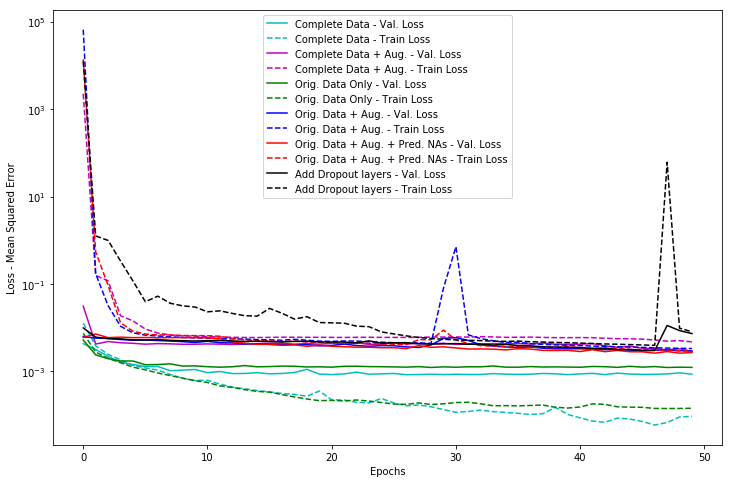

In [37]:
val_rms0a = hist0a['val_loss']
train_rms0a = hist0a['loss']
val_rms0b = hist0b['val_loss']
train_rms0b = hist0b['loss']
val_rms1 = hist1['val_loss']
train_rms1 = hist1['loss']
val_rms2 = hist2['val_loss']
train_rms2 = hist2['loss']
val_rms3 = hist3['val_loss']
train_rms3 = hist3['loss']
val_rms4 = hist4['val_loss']
train_rms4 = hist4['loss']

fig = plt.figure(figsize=(12,8))
plt.semilogy(val_rms0a, 'c-')
plt.semilogy(train_rms0a, 'c--')
plt.semilogy(val_rms0b, 'm-')
plt.semilogy(train_rms0b, 'm--')
plt.semilogy(val_rms1, 'g-')
plt.semilogy(train_rms1, 'g--')
plt.semilogy(val_rms2, 'b-')
plt.semilogy(train_rms2, 'b--')
plt.semilogy(val_rms3, 'r-')
plt.semilogy(train_rms3, 'r--')
plt.semilogy(val_rms4, 'k-')
plt.semilogy(train_rms4, 'k--')
plt.xlabel('Epochs')
plt.ylabel('Loss - Mean Squared Error')

plt.legend([
    'Complete Data - Val. Loss', 'Complete Data - Train Loss',
    'Complete Data + Aug. - Val. Loss', 'Complete Data + Aug. - Train Loss',
    'Orig. Data Only - Val. Loss', 'Orig. Data Only - Train Loss',
    'Orig. Data + Aug. - Val. Loss', 'Orig. Data + Aug. - Train Loss',
    'Orig. Data + Aug. + Pred. NAs - Val. Loss', 'Orig. Data + Aug. + Pred. NAs - Train Loss',
    'Add Dropout layers - Val. Loss', 'Add Dropout layers - Train Loss',
])

plt.show()

Here we are comparing the training performance of each of our CNN models. We tried running for longer than 50 epochs, but were limited by our hardware so we decided to cap it at 50 epochs. The dotted lines represent the training loss, and the solid lines represent the test loss. The lowest two lines represent the training loss on the complete data set with no missing values which is also being validated on the complete dev set with no missing values. You can see that we are starting to see pretty severe overfitting by the fact that the loss on the training data continues to trend downward, while the validation loss remains relatively flat. In general our models are converging fairly quickly, most of the time within the first 10 or 20 epochs. This is likely due to using the Adam optimizer which adapts the learning rate rapidly and converges much faster than traditional SGD. One notable exception is the fourth model where we added dropout layers and we can see the training loss converges much slower than the models with no dropout. There are two spikes that we see, the first blue spike we cannot explain, but the last spike in the dropout curve happened because our GPU ran out of memory and the training crashed.

# Visualize the Predictions

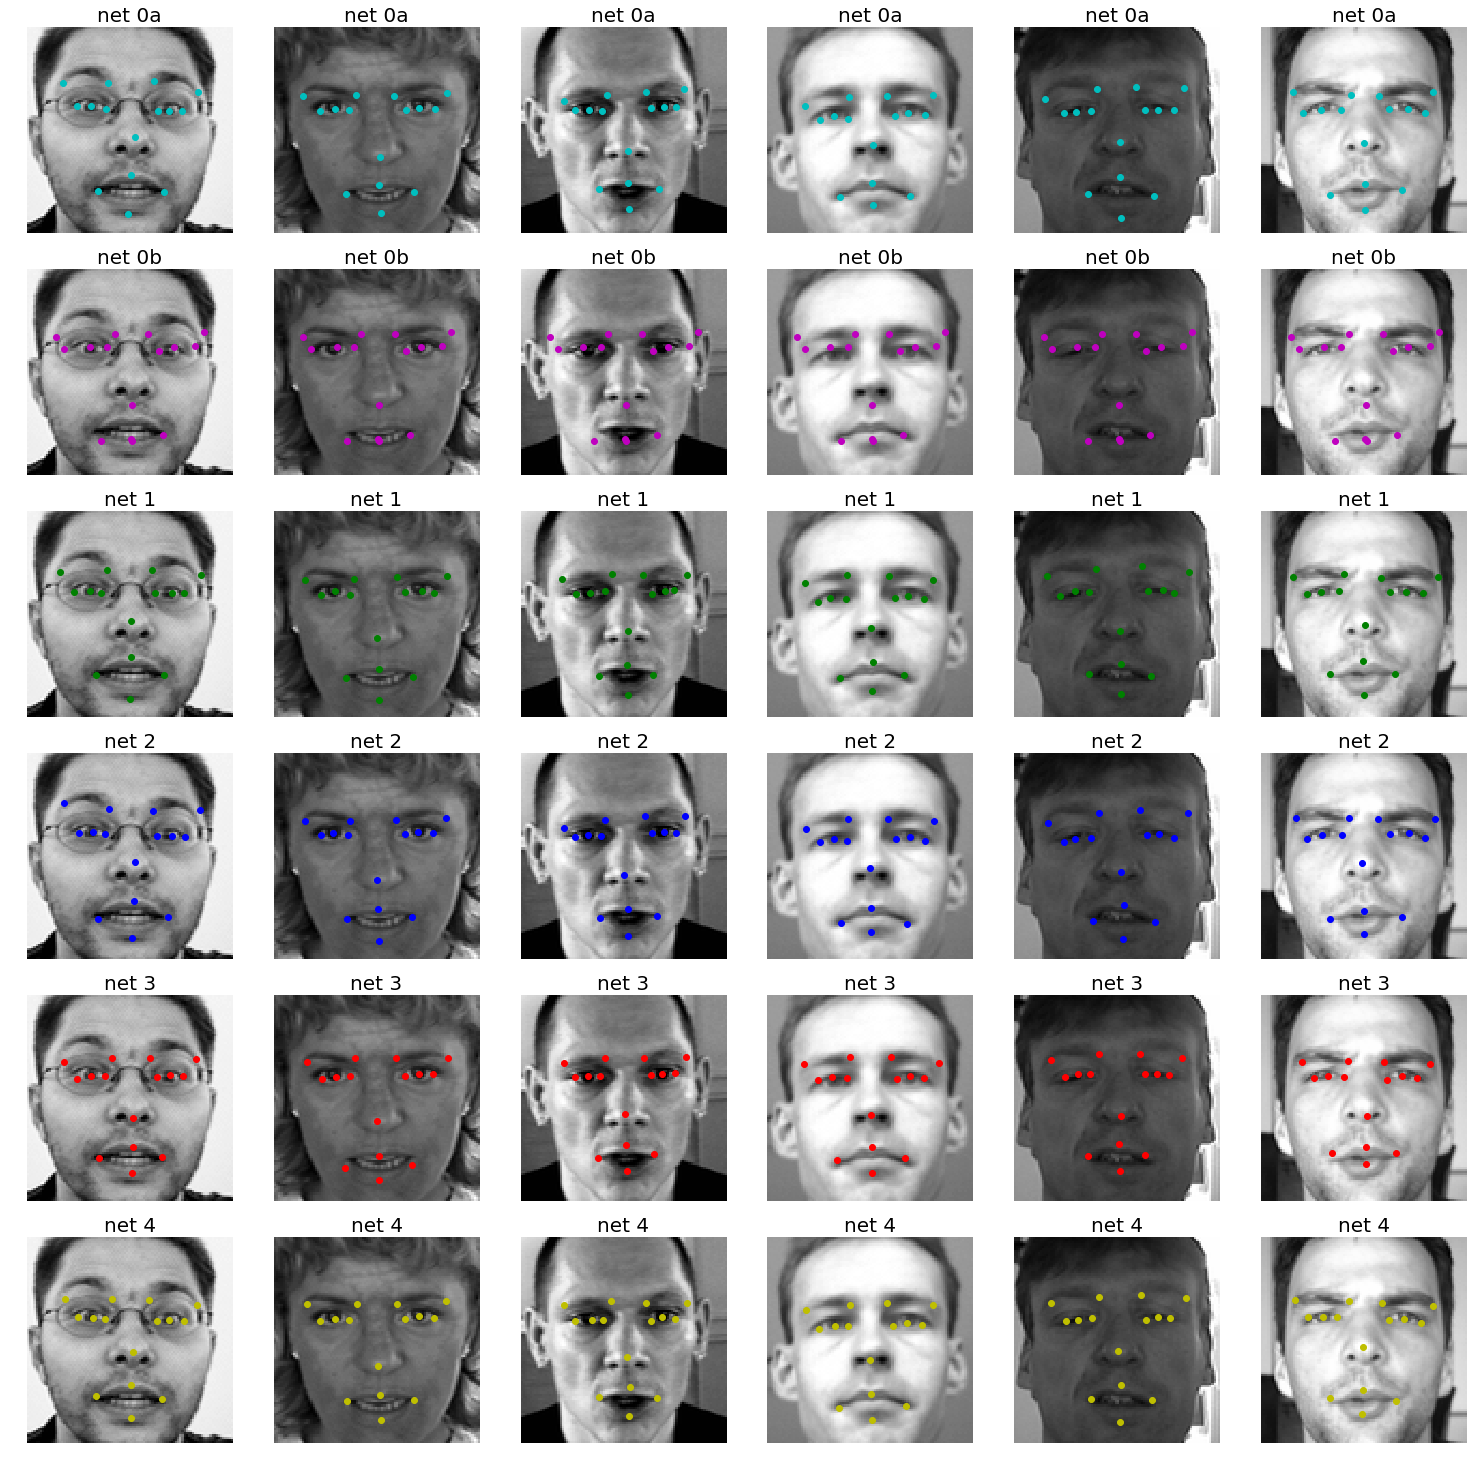

In [38]:
# pull in the predicted data
LUT = pd.read_csv('IDLookupTable.csv')
p0a = pd.read_csv('kaggle_model0a.csv')
p0b = pd.read_csv('kaggle_model0b.csv')
p1 = pd.read_csv('kaggle_model1.csv')
p2 = pd.read_csv('kaggle_model2.csv')
p3 = pd.read_csv('kaggle_model3.csv')
p4 = pd.read_csv('kaggle_model4.csv')

# reformat the predicted data
LUT['p0a'] = p0a.Location
LUT['p0b'] = p0b.Location
LUT['p1'] = p1.Location
LUT['p2'] = p2.Location
LUT['p3'] = p3.Location
LUT['p4'] = p4.Location

cols = {'p0a','p0b','p1','p2','p3','p4'}
labels = [
    np.array([LUT[col][LUT.ImageId == i+1].values for i in range(6)])
    for col in cols
]

# plot a sample
idx = list(range(6))
sample_data = test_data[idx]

fig, axes = plt.subplots(6,6,figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.2)
colors = ['c','m','g','b','r','y']
titles = ['net 0a', 'net 0b','net 1','net 2','net 3','net 4']
for i in range(6):
    for j in range(6):
        ax = axes[i,j]
        img = sample_data[j].reshape(96,96)
        labs = labels[i][j]
        ax.imshow(img, cmap='gray')
        ax.scatter(labs[::2], labs[1::2], c=colors[i])
        ax.set_title(titles[i], fontsize=20)
        ax.axis('off')

# Conclusion

### Summary Table

In [90]:
# Baseline Models

summary = pd.DataFrame.from_dict(result_dict)
summary = summary.head(2)
kaggle_scores = pd.DataFrame(
    [[4.46, 4.08, 4.74, 3.91, 3.96, 46.32, 4.96, 4.11, 4.07]], 
    columns=summary.columns.values
)
summary = summary.append(kaggle_scores, ignore_index=True)

In [91]:
# CNN Models

results = pd.read_csv('results.csv')
results.columns.values[0] = 'index'
results = results.head(3)

In [92]:
results_table = pd.concat([summary, results], axis=1)
results_table.to_csv('results_table_final.csv')

In [5]:
results_table = pd.read_csv('results_table_final.csv')
results_table.set_index(results_table['index'], inplace=True)
results_table = results_table.drop(['index'], axis=1)
results_table = results_table.T
results_table.columns.values[:] = ['Train RMSE', 'Dev RMSE', 'Test RMSE (Kaggle Score)']
results_table

index,Train RMSE,Dev RMSE,Test RMSE (Kaggle Score)
Training Average,3.72,NaN,4.46
LinearRegression_complete,0.00,2.56,4.08
DecisionTree_complete,0.00,3.39,4.74
RandomForest_complete,1.20,2.47,3.91
NearestNeighbors_complete,1.96,2.36,3.96
LinearRegression_complete_aug,0.00,227.09,46.32
DecisionTree_complete_aug,0.00,3.60,4.96
RandomForest_complete_aug,1.52,2.59,4.11
NearestNeighbors_complete_aug,2.62,2.43,4.07
CNN model0a,0.46,1.41,3.08


The table above summarize the performance of our models, both baseline and CNN. The first takeaway is that simply guessing average values for each label does relatively well: every other model performs within the same order of magnitude. However, significant improvement is certainly possible: the RMSE of the the most effective neural net is just over half of the RMSE of the "average location" baseline model.

The performance of the convolutional neural nets relative to the baseline models reinforces the decision to use them as our primary means of prediction. However, the results of our experimentation with data augmentation remain unclear. We would expect that data augmentation, performed here with the goal of increasing diversity in the training images, would have two effects - making training more difficult (in the sense that there are a wider variation in the predicted values that the model has to "explain") and making the model generalize better to atypical untrained faces.

The former assumption seems corroborated by our results, since the training error is significantly higher for models 0b and 2 than for their respective counterparts 0a and 1. The second assumption - that this more arduous training regimen will be rewarded in the form of better generalization - has some support. Certainly models 0a and 1, with remarkably low training errors and significantly higher validation errors, do not seem to generalize as well to their validation data as their augmented counterparts do. However, both the validation losses and the Kaggle scores speak to a larger issue: even if the generalization is better, it doesn't overcome the significant training advantage that the unaugmented data sets seem to enjoy. In both cases, the model trained on unaugmented data substantially outperforms its augmented counterpart on both the validation and test (submitted kaggle) data.

In the question of how to deal with NA values, the worst strategy seems to be to only train on "complete" data, i.e. to follow the strategy of models 0a and 0b. It is important to note that due to the structure of these models, the validation loss for models 0a and 0b was calculated on only completely labelled data. It is therefore only really appropriate to make comparisons to other models with respect to the kaggle submission scores. Here models 1 and 2 perform substantially better than 0a and 0b respectively. Since the data set models 0a and 0b were trained on was significantly smaller and tamer, it stands to reason that these models were not as well prepared to generalize to test data.

Both inferring the location of missing data (as in model 3) or selectively ignoring missing labels (as in model 1 and 2) seem to perform fairly well. The only direct comparison between these strategies is on augmented data, where the inference method in model 3 slightly outperforms the ignoring method in model 2. However, a comparison on unaugmented data should also be performed. 

The use of dropout layers to prevent overfitting in model 4 seems to have largely succeeded in limiting overfitting. We were unable to determine a kaggle score for this model as the GPU we were running it on ran out of memory at the last 2 epochs and we ran out of timet to perform a second run, but based on the validation score, we expect a kaggle score of roughly the same as model 2. The training and validation loss represent the scores from the 48th epoch. We don't see a huge improvement over no dropout here, however were we able to run for 100 or 1000 epochs we may expect to see performance increase over model 3.

A final observation on this summary is the substantial gap between validation scores and test scores. This could be a result of some systematic difference between test images and training/validation images, a result of unintentional overfitting (although the validation data were kept seperate from the training data, the presence of multiple photos of the same face in slightly different positions or expressions could lead to unobserved training/validation overlap), a systematic difference in the landmarks requested (for instance, if the kaggle score is based on a disporportionate number of "left eye outer corner"'s), or some other unforeseen problem. In the final section we will discuss potential ways to improve this score, as well as our performance in general.

### Further Research

In pursuit of both improved performance on test data and better understanding the effect of various parameters and features on the effectiveness of facial landmark detection, we would ideally continue with the following improvements and investigations. Many of the following were considered at various points in our process, however most fell beyond the scope and resources of our project. 
#### Image Augmentation: A Closer Examination
In the interest of significantly increasing the variation in our data, we applied several different forms of augmentation to our training images. However, a thorough examination of the effect of each kind of augmentation on the performance of the model could prove fruitful. What is the relative usefulness of each augmentation? For instance, how effective is training on a data set of 1000 images, compared to training on 1000 images and their appropriately labelled mirror images, compared to training on 2000 distinct images?
#### Preprocessing
In our exploration of image modification, we explored only the potential benefits of data augmentation - that is, increasing the number or variety of training images. This meant image modification was applied only to the training data, and as previously discussed, did not seem to improve performance on test data. An alternative approach to image modification would be the application of a modification such as blurring to both the training and test data. Rather than increasing variation in training data,this approach seeks to decrease variation both between and among the training and test sets. A few potential preprocessing steps include applying a blur filter (to eliminate or decrease variation in resolution, graininess, etc.), normalizing the brightness of images,or attempting to center or zoom in on distant or off-center images.
#### Shrinking the feature space
Currently, the inputs to our neural net occupy a feature space of:
$$\left(\text{256 values per pixel}\right)\times\left(\text{96 pixels wide}\right)\times\left(\text{96 pixels high}\right) = 2359296 \text{ possible combinations}
$$
Given the fact that the vast majority of these combinations are nonsense or noise, it seems appropriate to shrink the feature space into a more manageable size. This could be done by brute force, i.e. reducing the resolution of the image or the size of the colorspace, or with a more nuanced tool like principal component analysis. Reducing the size of the image itself has the added benefit of reducing the number of parameters in the dense layers, which could both speed training time and potentially prevent overfitting. Further research could look at the relative costs and benefits of various feature space reduction methods.
#### Test Data EDA
For the purposes of clean experimental design, we never did thorough analysis on the test data. However, one can imagine a scenario in which predicting labels for certain points on the test data represents a business application or other intrinsically valuable goal. In such a scenario - or if we just wanted to make our kaggle score get better - it could be worthwhile to more closely examine both the test images and the requested labels to better understand the nature of the predictions that should be made, and the kinds of images we need to be able to handle.

## Thank you for taking the time to read about our project. 

# Sources

 - http://deeplearning.net/tutorial/lenet.html#lenet
 - https://arxiv.org/abs/1206.5533
 - https://arxiv.org/abs/1412.6980v8
 - http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/
 - https://arxiv.org/abs/1710.05279
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4978658/

# Appendix

## Erroneous Data Algorithm

#### Note: It is not recommended to run this cell because it is out of sequence

During our EDA, we incidentally discovered that some data was very clearly mislabeled, so we decided to search for and remove bad data to reduce noise. Since the data set is large, we needed an algorithm to flag likely bad data. Our method of choice was to train our CNN model on the full training data, then use that model to predict values _on the training data_, flagging any image where a single keypoint was off by 40 pixels or more. We threw out 69 images that met this criterion. A few images looked mostly correct and may have been collateral damage. A further improvement attempt could be to only throw out the keypoints that were questionable and keep the ones that looked good. We did want to be wary of throwing out too much, since we were training on the same data we were predicting on, so our predictions were only so reliable. Another possible improvement could be to incorporate cross-validation within the training set for this error identification exercise.

In [ ]:
model1 = build_CNN()

time_callback = TimeHistory()
hist = keras.callbacks.History()

model1.fit(
    train_data_raw, train_labels_raw, 
    batch_size=32,
    epochs=1, 
    verbose=1,
    callbacks=[hist, time_callback]
)
predictions = model1.predict(train_data_raw, verbose=1)

# get array of squared errors
error = predictions*96 - train_labels_raw*96
sq_err = error ** 2

# flag any images where a single keypoint dimension is off by a threshold distance
flagged = []
for i in range(sq_err.shape[0]):
    threshold = 40
    if np.any(sq_err[i] > threshold ** 2):
        flagged.append(i)
print(flagged)

# plot these images as a sanity check that they are in face "bad" data
i = 0
rows = 8
cols = len(flagged)//rows + 1
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for index in flagged:
    ax = fig.add_subplot(rows, cols, i + 1, xticks=[], yticks=[])
    ax.imshow(train_data_raw[index].reshape(96,96), cmap='gray')
    ax.scatter(train_labels_raw[index][0::2] * 48 + 48, train_labels_raw[i][1::2] * 48 + 48, c='r')
    i += 1